In [230]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from scipy import signal, interpolate, fftpack # signal processing lib
import glob
import pyarrow.csv # faster .csv I/O than in pandas
from tqdm import tqdm # pretty loading bar
import matplotlib.pyplot as plt
import math

# Input data files are available in the read-only "../input/" directory

In [231]:
ROOT = "../input/neymark-signal-processing/watch_data_test/watch_data_test/"
ROOT_TRAIN = "../input/neymark-signal-processing/watch_data_train/watch_data_train/"
SUBMISSION_SR = 30 # sampling rate for the submission file

## Функция визуализации

In [253]:
def do_visualize(x, y, ecg, peaks, sample_size=10000, sample_shift=0, details=0, title=''):
    plt.plot(
        x[sample_shift:sample_size + sample_shift],
        y[sample_shift:sample_size + sample_shift]
    ) # signal
    if details > 0:
        x[peaks[np.where((peaks > sample_shift) & (peaks < sample_shift + sample_size))]]
        c = np.count_nonzero(x[peaks[np.where((peaks > sample_shift) & (peaks < sample_shift + sample_size))]])
        title = f"{title} (count: {c})"
        plt.plot(
            x[peaks[np.where((peaks > sample_shift) & (peaks < sample_shift + sample_size))]],
            y[peaks[np.where((peaks > sample_shift) & (peaks < sample_shift + sample_size))]],
            "o",
            color="r"
        ) # founded peaks
        if details > 1:
            ct = np.count_nonzero(ecg[ecg < x[sample_shift + sample_size]][ecg > x[sample_shift]])
            title = f"{title} (true: {ct})"
            plt.vlines(
                ecg[ecg < x[sample_shift + sample_size]][ecg > x[sample_shift]],
                ymin=0,
                ymax=1,
                alpha=0.5,
                color="gray"
            ) # ECG peaks
    if title != '':
        plt.title(title)
    plt.show()

Визуализируем один из сигналов.

In [233]:
ppg_sample = pyarrow.csv.read_csv(f"{ROOT_TRAIN}PPG_EXP_1.csv").to_pandas()
ecg_sample = pyarrow.csv.read_csv(f"{ROOT_TRAIN}ECG_EXP_1.csv").to_pandas()

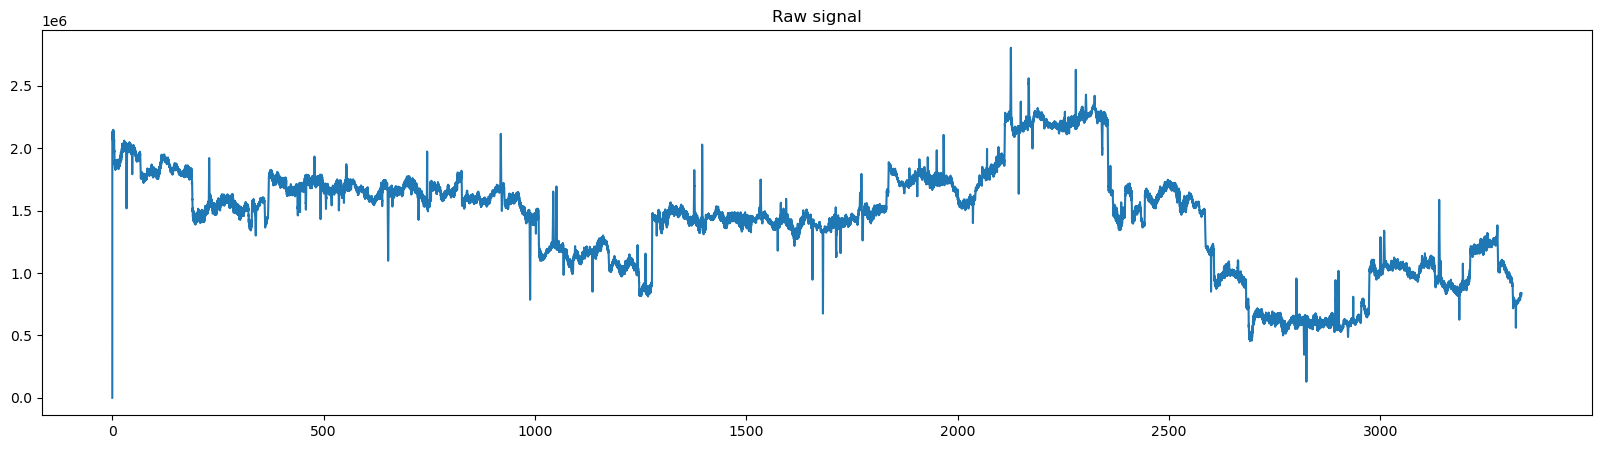

In [254]:
plt.rcParams["figure.figsize"] = (20,5)

do_visualize(
    ppg_sample['Timestamp'],
    ppg_sample['PPG_signal'],
    ecg_sample['ECG_peaks'],
    peaks=founded_peaks,
    sample_size=100000,
    title='Raw signal'
)

Заметна неровность сигнала и наличие выбросов.

## Функция поиска пиков в сигнале
- фильтр по интервалу частот
- логарифмическое масштабирование
- удаление выбросов
- нормализация

In [235]:
def ppg_find_peaks(data, min_frequency=5, max_frequency=80, p=0.15, edge=300, dist=1, log=5, h=True):

    # фильтр частот (на основе быстрого преобразования Фурье)
    d = np.abs(fftpack.fft(data))
    d[:3] = 0
    frequencies = np.linspace(0, edge, len(d))
    band_filter = np.zeros(len(frequencies))
    band_filter[(frequencies > min_frequency) & (frequencies < max_frequency)] = 1
    spectrum = fftpack.fft(data)
    spectrum[band_filter == 0] = 0
    y = fftpack.ifft(spectrum).real
    
    # логарифмическое масштабирование
    log_y = lambda x: math.log(x, log) if x > 0 else 0
    y = np.array(list(map(log_y, y)))

    # удаление выбросов
    if h:
        b_min = int(y[1000:1700].min() * 0.9)
        b_max = int(y[1000:1700].max() * 1.03)
        y[y < b_min] = b_min
        y[y > b_max] = b_max

    # нормализация сигнала (0, 1)
    v_min = y.min()
    v_max = y.max()
    y = (y - v_min) / (v_max - v_min)
    
    peaks = signal.find_peaks(y, prominence=p, distance=dist)[0]

    return peaks, y

## Функция расчета метрики accuracy

In [236]:
def accuracy_counter(gt_peak_ts, device_peak_ts, threshold=0.015):

    #Finds RR-accuracy in n*logn. RR-accuracy is defined as TP/(TP + FP + FN), where TP - true positive, FP - false positive, FN - false negative.
    #A true positive is when the peak is detected and there is a GT (ground truth) peak within threshold seconds nearby.
    #A false positive is when the peak is detected, but there is no GT peak nearby.
    #A false negative is when there is a GT peak, but it's not detected.

    tps = 0
    fns = 0
    fps = 0
    for device_peak in device_peak_ts:
        closest_index = np.searchsorted(gt_peak_ts, device_peak, side='left')
        if closest_index == len(gt_peak_ts):
            closest_index -= 1
        tp = np.abs(gt_peak_ts[closest_index] - device_peak) <= threshold
        if not tp and closest_index > 0: # np.searchsorted design artifact
            closest_index -= 1
            tp = np.abs(gt_peak_ts[closest_index] - device_peak) <= threshold
        tps += int(tp)
        fps += 1 - int(tp)
    for gt_peak in gt_peak_ts:
        closest_index = np.searchsorted(device_peak_ts, gt_peak, side='left')
        if closest_index == len(device_peak_ts):
            closest_index -= 1
        tp = np.abs(device_peak_ts[closest_index] - gt_peak) <= threshold
        if not tp and closest_index > 0:
            closest_index -= 1
            tp = np.abs(device_peak_ts[closest_index] - gt_peak) <= threshold
        fns += 1 - int(tp)
    accuracy = tps / (tps + fps + fns)
    return accuracy

## Функция обработки набора тренировочных данных

In [245]:
def do_experiment(min_frequency, max_frequency, p_n, edge=300, dist=1, log=5, visualize=False, sample_size=700, sample_shift=0):
    train_ppgs_pathes = glob.glob(f"{ROOT_TRAIN}PPG_EXP_*.csv")
    train_ppgs_pathes.sort()
    for file_name in train_ppgs_pathes:
        num_begin = int(file_name.find('EXP_'))
        num_end = int(file_name.find('.csv'))
        file_num = file_name[num_begin + 4:num_end]
        sample_ppg_path = f"{ROOT_TRAIN}PPG_EXP_{file_num}.csv"
        sample_ecg_path = f"{ROOT_TRAIN}ECG_EXP_{file_num}.csv"
        ppg_sample = pyarrow.csv.read_csv(sample_ppg_path).to_pandas()
        ecg_sample = pyarrow.csv.read_csv(sample_ecg_path).to_pandas()

        founded_peaks, y = ppg_find_peaks(ppg_sample['PPG_signal'].values, min_frequency, max_frequency, p_n, edge, dist, log)

        # accuracy
        timestamps = ppg_sample['Timestamp'].values
        gt_peaks = ecg_sample['ECG_peaks'].values
        g_peaks = timestamps[founded_peaks]
        acc = round(accuracy_counter(gt_peaks, g_peaks), 5)

        if visualize:
            do_visualize(
                ppg_sample['Timestamp'],
                y,
                ecg_sample['ECG_peaks'],
                founded_peaks,
                sample_size,
                sample_shift,
                details=2,
                title=f"Sample {file_num} (acc: {acc})"
            )

Подбираем гиперпараметры

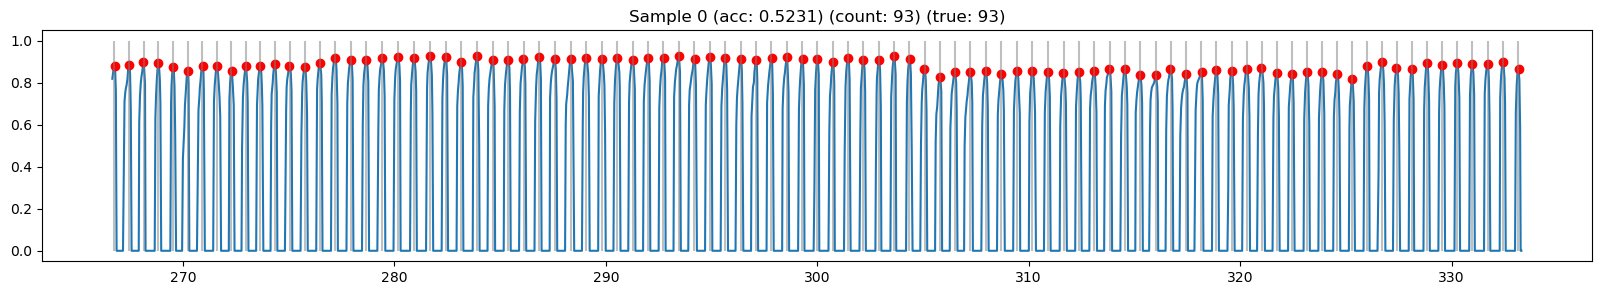

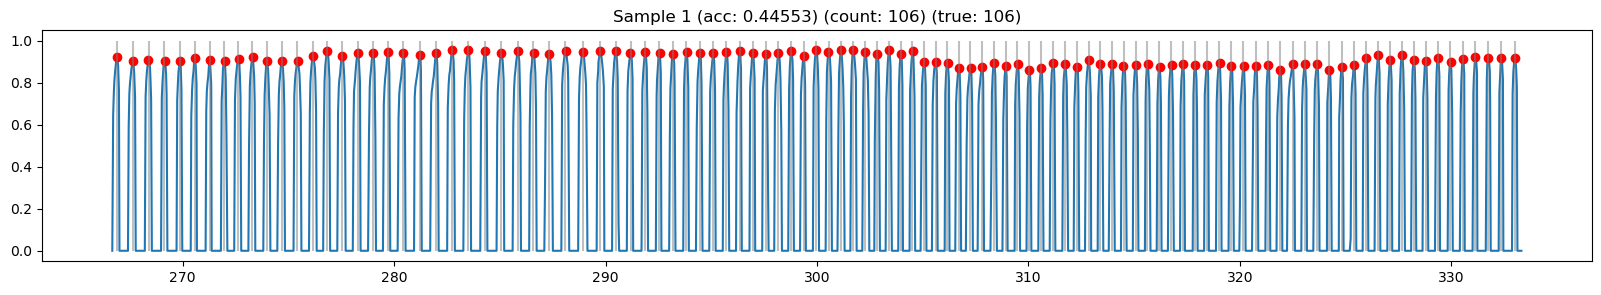

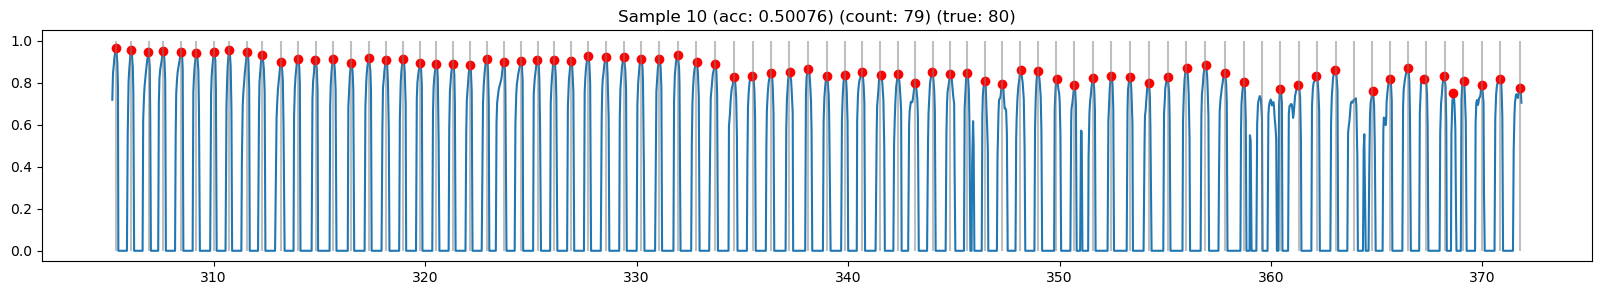

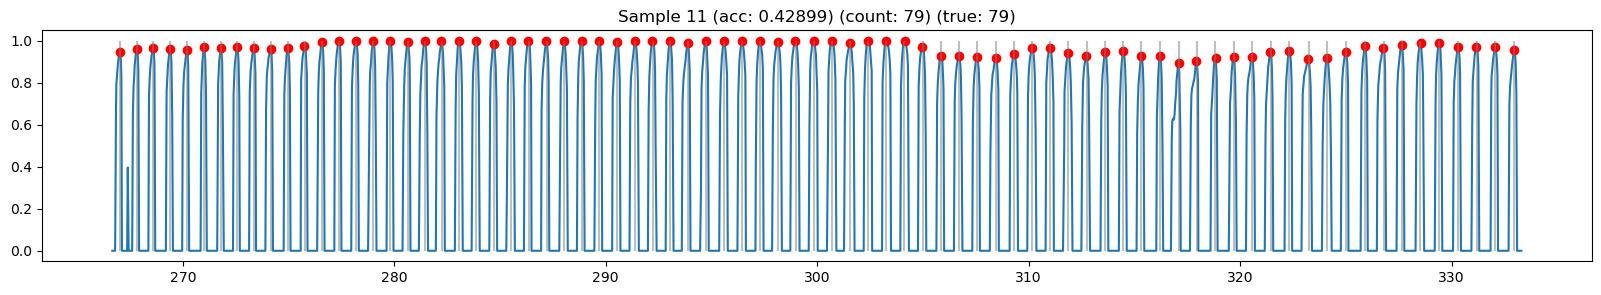

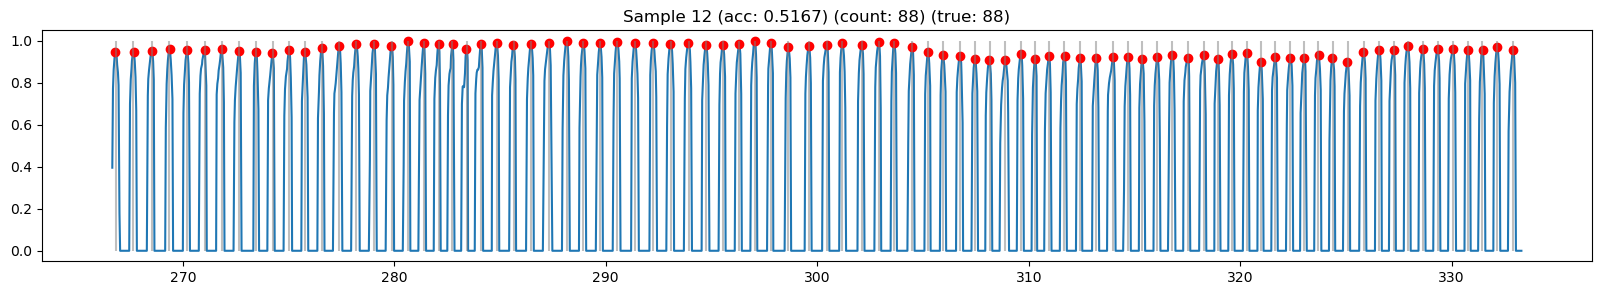

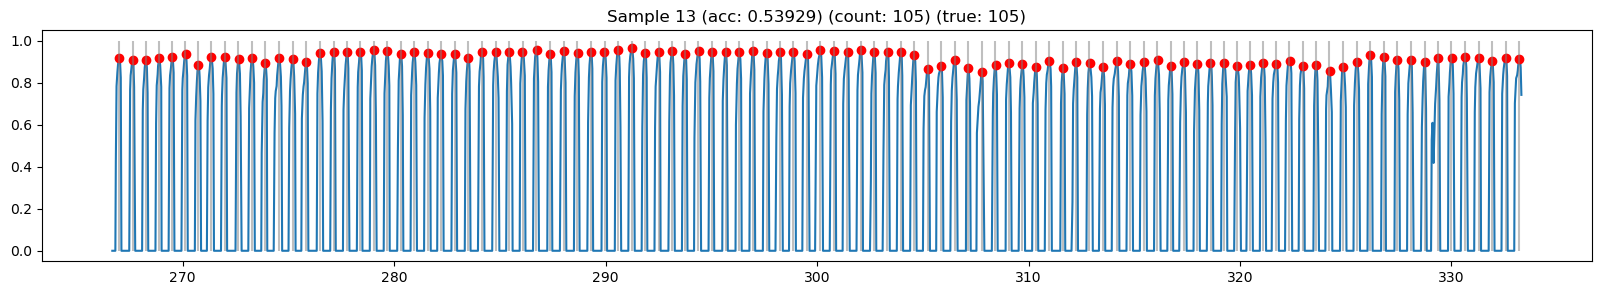

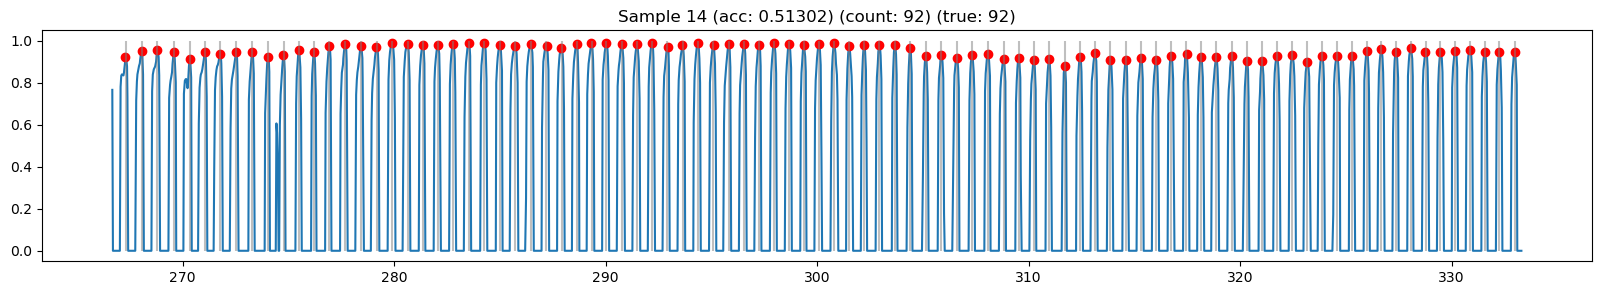

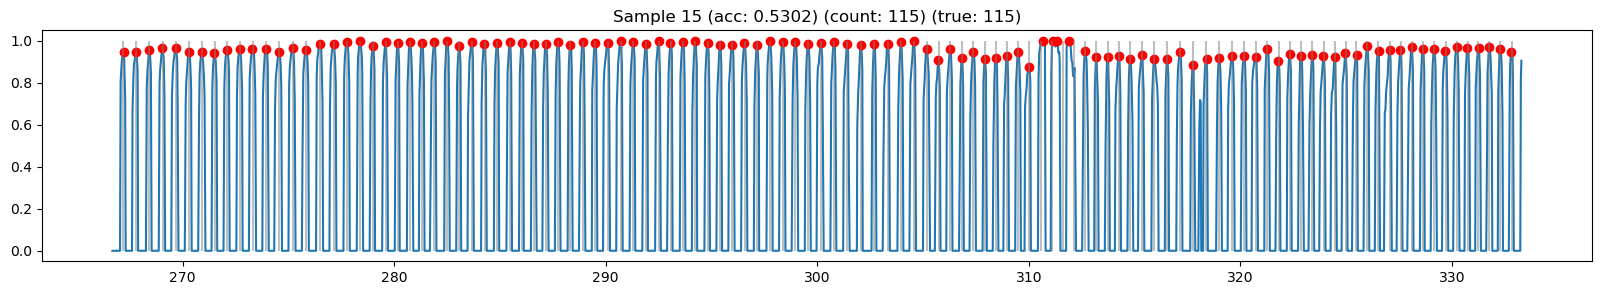

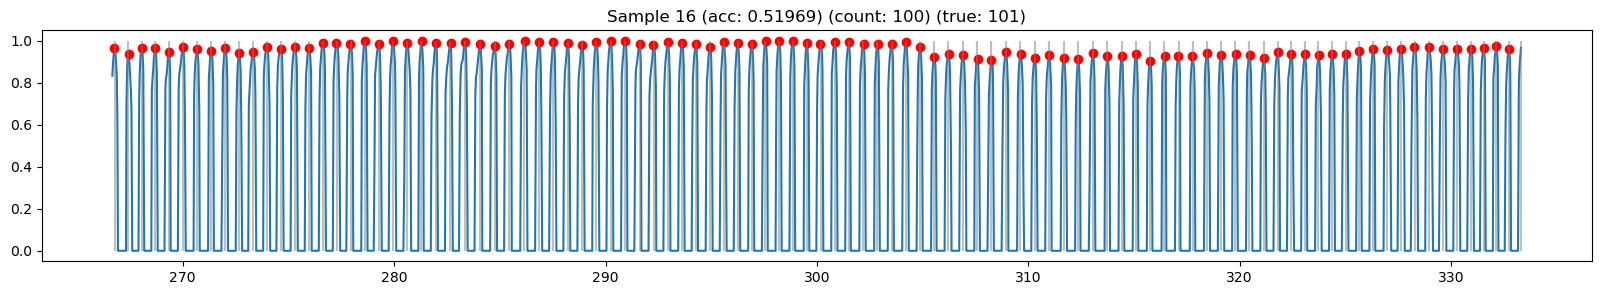

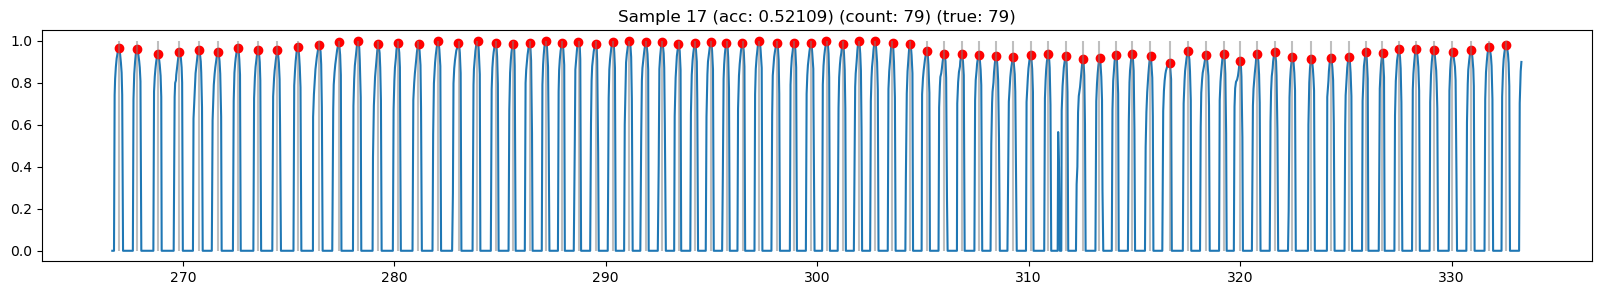

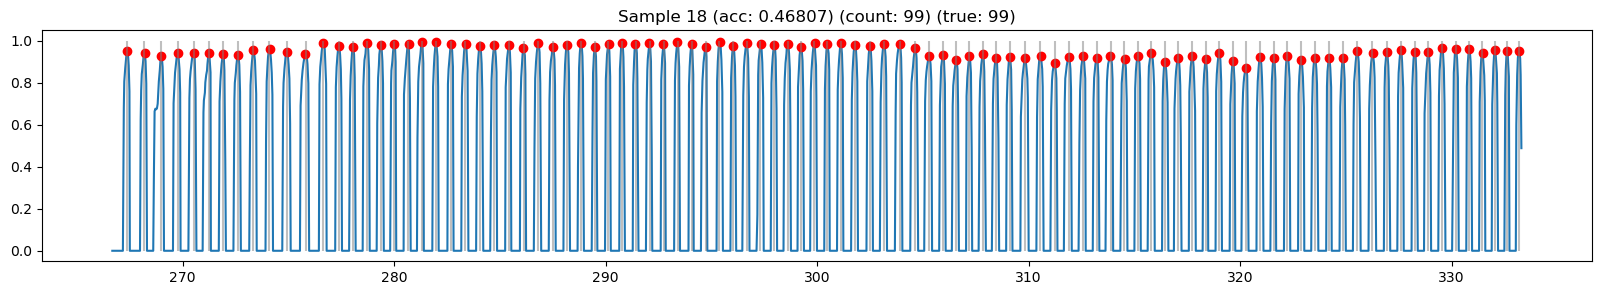

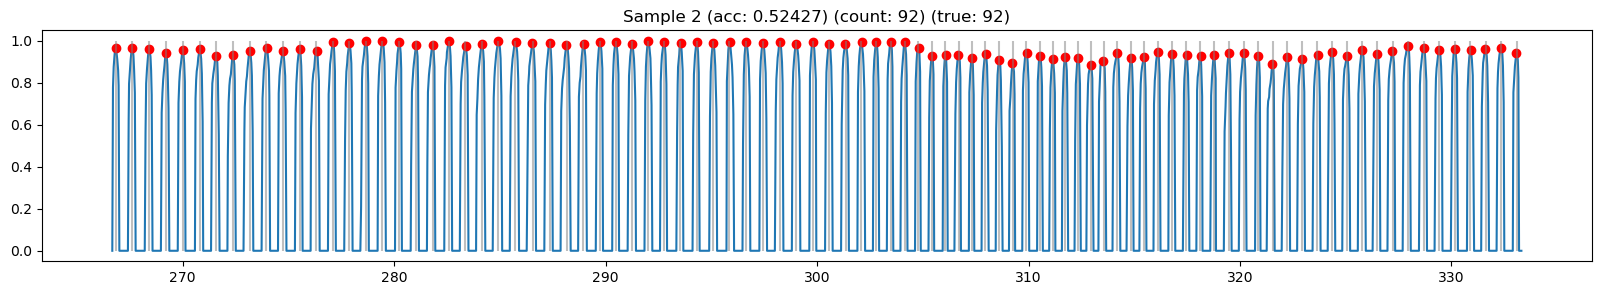

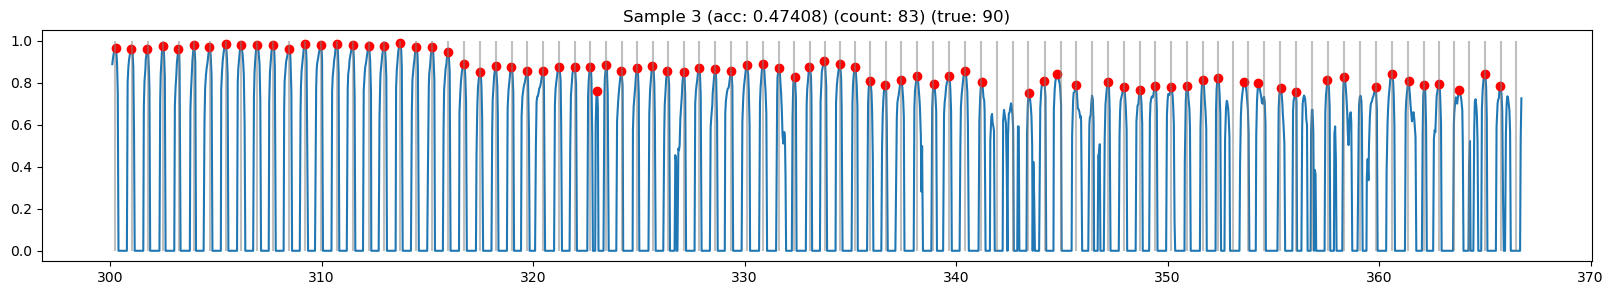

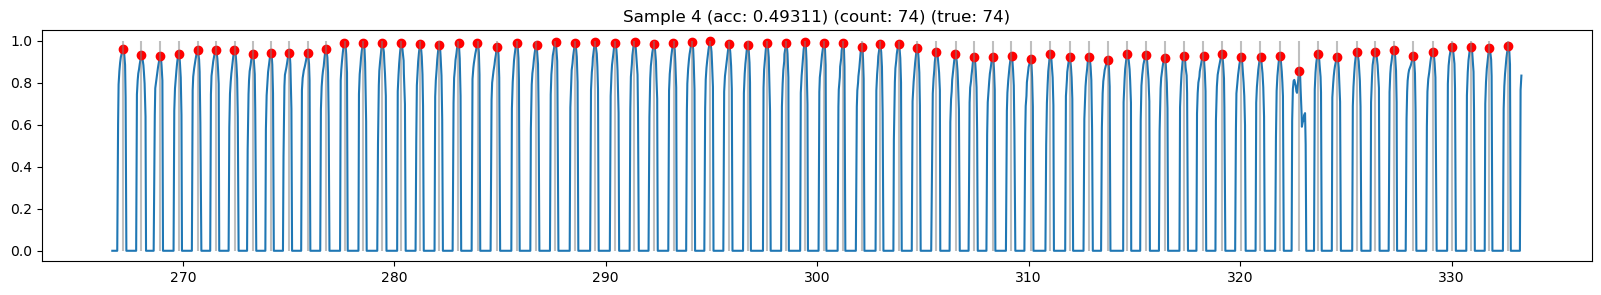

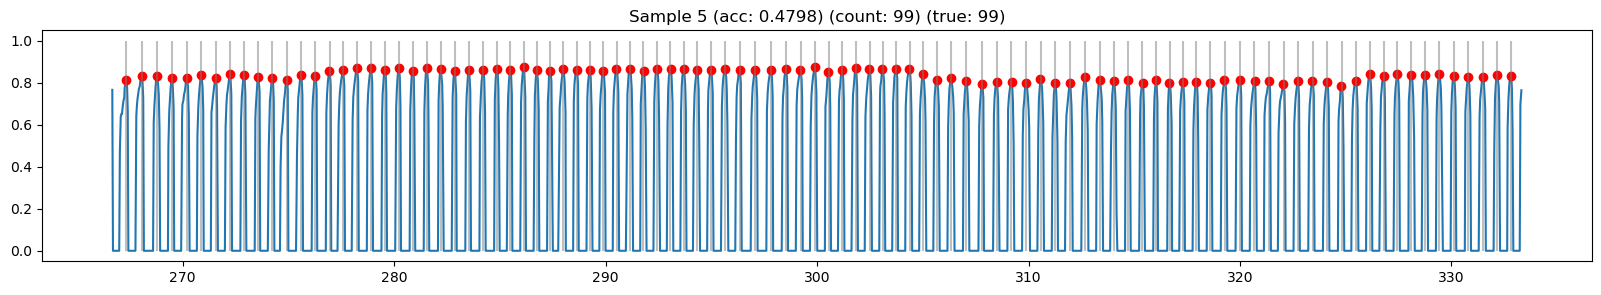

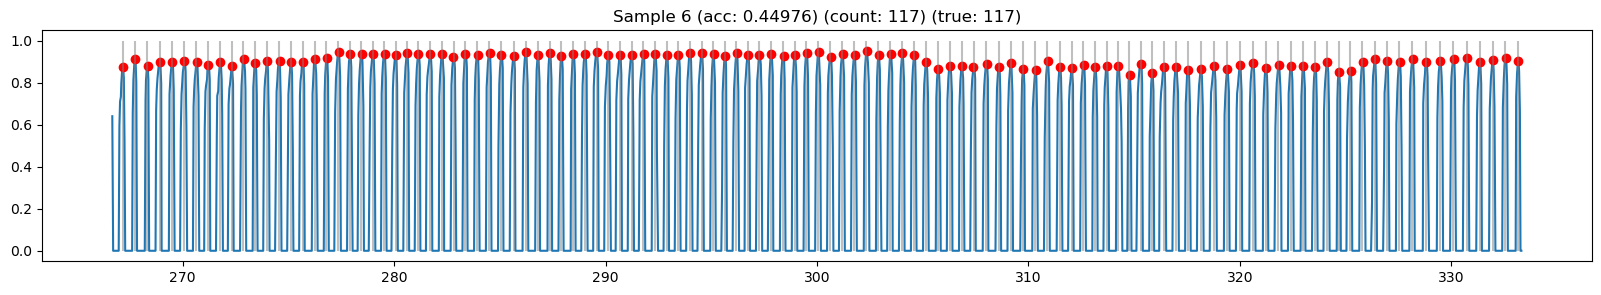

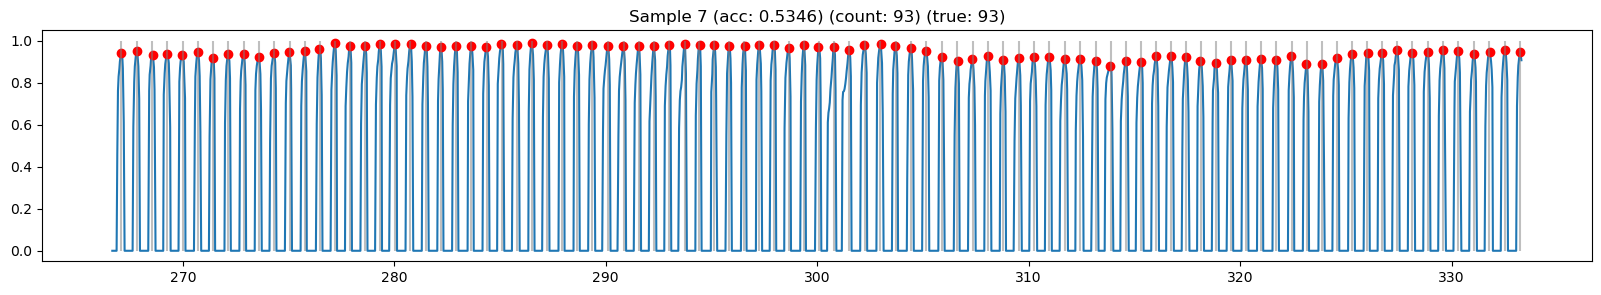

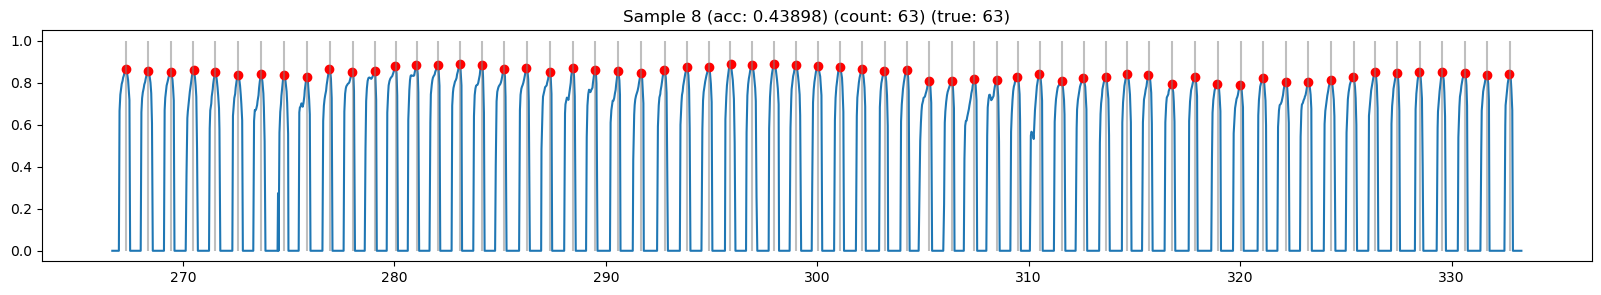

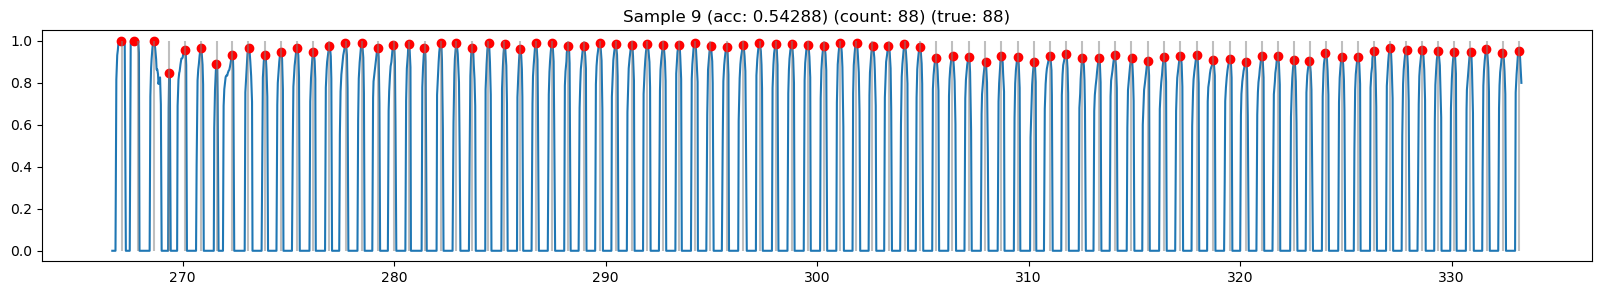

In [255]:
plt.rcParams["figure.figsize"] = (20,3)

do_experiment(9, 90, 0.75, edge=300, dist=5, log=1.05, visualize=True, sample_size=2000, sample_shift=8000)

## Формируем данные для загрузки

In [118]:
def format_peaks_to_intervals(ppg_peaks, ts_start, ts_finish):
    """
    Formats the detected heart beat timestamps into the sequence of interbeat intervals. 
    The test ECG peaks are formatted in the same way.
    The start and finish of each experiment are the start and finish of the PPG data.
    """
    timestamps_interp = np.linspace(ts_start, ts_finish, int((ts_finish - ts_start) * SUBMISSION_SR))
    heartbeat_intervals = np.diff(ppg_peaks, prepend=ts_start)
    func = interpolate.interp1d(ppg_peaks, heartbeat_intervals, "nearest", bounds_error=False, fill_value=0)
    heartbeat_intervals_interp = func(timestamps_interp)
    return heartbeat_intervals_interp

In [158]:
def process_exp(ppg_df):
    ppg_signal = ppg_df['PPG_signal'].values
    timestamps = ppg_df['Timestamp'].values

    #ppg_peak_idxs = signal.find_peaks(ppg_signal)[0]
    ppg_peak_idxs, _ = ppg_find_peaks(ppg_signal, 9, 90, 0.75, edge=300, dist=1, log=1.05)

    ppg_peaks = timestamps[ppg_peak_idxs]
    ppg_rr_intervals_interp = format_peaks_to_intervals(ppg_peaks, timestamps[0], timestamps[-1])
    return ppg_rr_intervals_interp

In [159]:
test_ppgs_pathes = glob.glob(f"{ROOT}PPG_EXP_*.csv")
test_ppgs_pathes.sort()
all_predictions = []
for path in tqdm(test_ppgs_pathes):
    ppg_df = pyarrow.csv.read_csv(path).to_pandas()
    ppg_rr_intervals_interp = process_exp(ppg_df)
    all_predictions.append(ppg_rr_intervals_interp)
all_predictions = np.concatenate(all_predictions)
sample_summission = pd.DataFrame({"PPG_interbeat_interval": all_predictions})
sample_summission['id'] = sample_summission.index
sample_summission.to_csv("submission.csv", index=None)

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]
